In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from astropy import units as u
from astropy import constants as const
from flux_utils import flux_conversion, bands, colors, convert_radio
from data import vla_data, photometry_data, t_neutrino, t_peak_mjd, bran_disc, meerkat_data, xray_data, vla_data, gamma_data, gamma_deintegrate, bran_disc
from plots import fig_width, fontsize

NameError: name 'xray_ul_data' is not defined

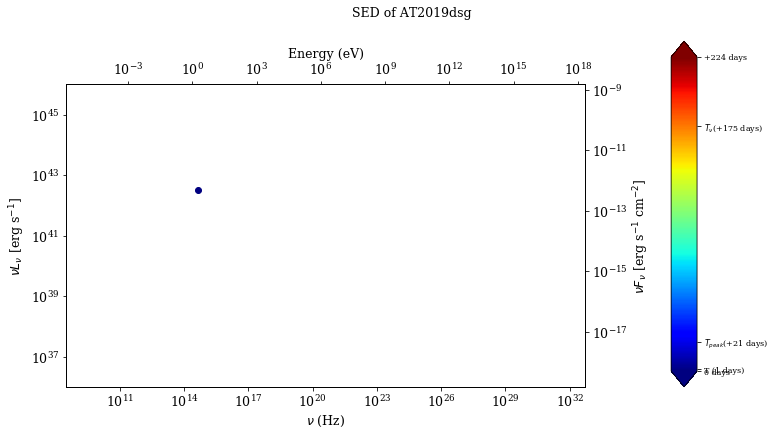

In [3]:
times = []
delta_lum = []

t_offset = bran_disc.mjd - t_peak_mjd.mjd

fig = plt.figure(figsize=(fig_width*2, fig_width))

start_bin = 5

photon_index = []
index_times = []

ls = []

cmap = "plasma"
cmap = "jet"

def col(times, time_scale):
    norm = matplotlib.colors.Normalize(vmin=0.0, vmax=time_scale, clip=True)
    mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    return mapper.to_rgba(times)


ax = fig.add_axes([0.1, 0.1, 0.6, 0.7]) 
ax.set_yscale("log")
ax.set_xscale("log")
lower_x = 1.0 * 10**8.5
upper_x = 5. * 10 ** 32
ax.set_xlim(lower_x, upper_x)
ax2 = ax.twiny()
ax2.set_xlim((u.Hz * lower_x * const.h).to("eV").value, (u.Hz * upper_x*const.h).to("eV").value)
ax2.set_xscale("log") 
lower_y = 10.**36
upper_y = 10.**46
ax.set_ylim(lower_y, upper_y)
ax3 = ax.twinx()
ax3.set_yscale("log")
ax3.set_ylim(lower_y*flux_conversion, upper_y*flux_conversion)
ax3.set_ylabel(r"$\nu F_{\nu}$ [erg s$^{-1}$ cm$^{-2}$]", fontsize=fontsize)
cbaxes = fig.add_axes([0.8, 0.1, 0.03, 0.8]) 
cbar = plt.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap), extend='both', cax = cbaxes)
ax.tick_params(axis='both', which='both', labelsize=fontsize)
ax2.tick_params(axis='both', which='both', labelsize=fontsize)
ax3.tick_params(axis='both', which='both', labelsize=fontsize)
plt.suptitle("SED of AT2019dsg", fontsize=fontsize)
ax.set_xlabel(r"$\nu$ (Hz)", fontsize=fontsize)
ax2.set_xlabel("Energy (eV)", fontsize=fontsize)
ax.set_ylabel(r"$\nu L_{\nu}$ [erg s$^{-1}$]", fontsize=fontsize)

gx = 0.5*(gamma_data["MJD_start"] + gamma_data["MJD_stop"]) - bran_disc.mjd
xerr = 0.5*(gamma_data["MJD_stop"] - gamma_data["MJD_start"])

x = np.array([0.1 * 10**9, 800. * 10**9]) * (u.eV / const.h).to("Hz").value
lim = (1.2091246077564326e-06 * u.MeV /u.cm**2 / u.s).to("erg cm-2 s-1").value/flux_conversion
y = lim * np.ones_like(x)

ax2.errorbar(x, y, yerr=0.5*y, uplims=True, color="k")

# x = [200 * 10**12, 10*10.**15]
# ul_txs = 3.2 * 10 **-11./flux_conversion
# ul_1year_ehe = ul_txs *7.5
# ratio_ehe_gold = 6.6 / 2.1 # ICRC REALTIME PAPER RATIO GOLD TO EHE
# ul_1year_gold = ul_1year_ehe / ratio_ehe_gold

# y = ul_1year_gold * np.ones_like(x)

# ax2.errorbar(x, y, yerr=y*0.5, uplims=True, color="r")
# ax2.plot(x, y/10.,  color="r", linestyle=":")
# ax2.plot(x, y/100., color="r", linestyle=":")

frames = 80


def update_plot(j):
    
    bins = np.linspace(0.0, max(photometry_data["#day_since_peak"]) - t_offset, frames + 1)
    time_scale = bins[-1] - bins[0] 
    lower = bins[j]
    upper = bins[j + 1]
    
    t = np.mean([lower, upper])
    cbar.set_ticks([
        0.0,
        (t-bins[0])/time_scale,
        -t_offset/time_scale,
        (t_neutrino.mjd - bran_disc.mjd)/time_scale,  
        1.0
    ]
    )
    
    cbar.set_ticklabels([
        f"{bins[0]:.0f} days",
        f"T ({t:.0f} days)",
        r"$T_{peak}$" + "(+{0:.0f} days)".format(-t_offset),
        r"$T_{\nu}$" + "(+{0:.0f} days)".format(t_neutrino.mjd - t_peak_mjd.mjd - t_offset),
        f"+{bins[-1]:.0f} days"
    ])

    mask = np.logical_and(
        photometry_data["#day_since_peak"] - t_offset > lower,
        photometry_data["#day_since_peak"] - t_offset < upper,
    )
                
    data = photometry_data[mask]
    
    fs = []
    lums = []

    for band in list(set(data["band"][mask])):
        if band in bands:
            wl = bands[band].to("m")
            f = (const.c / wl).to("Hz")
            
            bmask = np.logical_and(
                data["band"] == band,
                data["lum"] > 0.
            )

            bd = data[bmask]["lum"]
#             err = data[data["band"] == band]["lum"]
#             bd = np.array(list(bd[bd > 0]))
                
            x = np.ones_like(bd) * f.value
            if len(bd) > 0:
                ax.scatter(
                    x,
                    bd,
                    c=data[bmask]["#day_since_peak"],
                    cmap=cmap,
                    vmin=bins[0],
                    vmax=bins[-1]
                ) 
                fs.append(f.value)
                lums.append(np.mean(bd))
            
    radio_times = vla_data.sort_values("mjd")["mjd"] - bran_disc.mjd
    
    try:
        min_x = min(fs)
        max_x = max(fs)
    except ValueError:
        min_x = 1.
        max_x = 1.
        
    mask = np.logical_and(
        radio_times > lower,
        radio_times < upper
    )
        
    if np.sum(mask) > 0:
                
        ax.scatter(
            vla_data["frequency"][mask] * 10 ** 9, 
            convert_radio(vla_data["flux"], vla_data["frequency"])[mask]/flux_conversion, 
            marker="o", 
            c=radio_times[mask], 
            cmap=cmap, 
            vmin=bins[0],
            vmax=bins[-1]
        )

#         ax.errorbar(
#             vla_data["frequency"][mask] * 10 ** 9, 
#             convert_radio(vla_data["flux"], vla_data["frequency"])[mask]/conversion,  
#             yerr=convert_radio(vla_data["flux_err"], vla_data["frequency"])[mask]/conversion, 
#             marker="o", 
#             color=list(c)
#         )
        min_x = min(list(vla_data["frequency"][mask])) * 10 ** 9
        
    meerkat_times = meerkat_data["#mjd"] - bran_disc.mjd
    
    mask = np.logical_and(
        meerkat_times > lower,
        meerkat_times < upper
    )
        
    if np.sum(mask) > 0:
        f = 1.4 * 10 ** 9
        
        ax.scatter(
            f,
            convert_radio(meerkat_data["flux_mJy"], f*10**-9)[mask]/flux_conversion, 
            marker="o", 
            c=meerkat_times[mask], 
            cmap=cmap, 
            vmin=bins[0],
            vmax=bins[-1]
        )
        min_x = min([f, min_x])
        
    xray_times = xray_data["#MJD"] - bran_disc.mjd
        
    mask = np.logical_and(
        xray_times > lower,
        xray_times < upper
    )
    
    if np.sum(mask) > 0:
        for index, entry in xray_data[mask].iterrows():  
        
            x = [0.1, 10]
            f = [((a * u.keV) / const.h).to("Hz").value for a in x]

            f_mid = np.exp(np.mean(np.log(f)))
            f_err = np.array([(f_mid - f[0], f[1] - f_mid)]).T

            y = entry["flux"]/flux_conversion
        
            ax.errorbar(
                f_mid,
                y,
                xerr=f_err,
                fmt=' ',
#                 marker="o",
                c=col(xray_times[index], time_scale), 
            )
    
#     if np.sum(mask) > 0:
#         f = ((5 * u.keV) / const.h).to("Hz").value
        
#         y = (10 ** xray_data["log_lum"])[mask]
#         x = np.ones_like(y) * f
        
#         ax.scatter(
#             x,
#             y,
#             marker="o",
#             c=xray_times[mask], 
#             cmap=cmap, 
#             vmin=bins[0],
#             vmax=bins[-1]
#         )
#         max_x = f
        
    xray_ul_times = xray_ul_data["#MJD"] - bran_disc.mjd
    
    mask = np.logical_and(
        xray_ul_times > lower,
        xray_ul_times < upper
    )
    
    if np.sum(mask) > 0:
        for index, entry in xray_ul_data[mask].iterrows():  
        
            x = [0.1, 10]
            f = [((a * u.keV) / const.h).to("Hz").value for a in x]

            f_mid = np.exp(np.mean(np.log(f)))
            f_err = np.array([(f_mid - f[0], f[1] - f_mid)]).T

            y = entry["flux"]/flux_conversion
        
            ax.errorbar(
                f_mid,
                y,
                yerr=0.8*y,
                xerr=f_err,
                uplims=True,
                fmt=' ',
                zorder=j,
                c=col(xray_ul_times[index], time_scale), 
            )
            
        
    mask = np.logical_and(
        gamma_data["MJD_start"] - bran_disc.mjd < upper,
        gamma_data["MJD_stop"] - bran_disc.mjd  > lower
    )
        
    if np.sum(mask) > 0:
        for index, entry in gamma_data[mask].iterrows():  
            
            if index > 1:
                continue
        
            x = [0.1, 800]
            f = [((a * u.GeV) / const.h).to("Hz").value for a in x]

            f_mid = np.exp(np.mean(np.log(f)))
            f_err = np.array([(f_mid - f[0], f[1] - f_mid)]).T

            y = entry["UL(95)"]/flux_conversion
            
            ct = np.mean([entry["MJD_start"], entry["MJD_stop"]]) - bran_disc.mjd
                        
            ax.errorbar(
                f_mid,
                y,
                yerr=0.4*y,
                xerr=f_err,
                uplims=True,
                fmt=' ',
                c=col(ct, time_scale), 
            )

#         x_mid = np.exp(np.mean(np.log(x)))
#         x_err = np.array([(x_mid - x[0], x[1] - x_mid)]).T
#         ax3.errorbar(
#             x_mid,
#             gamma_data["UL(95)"][mask],
#             xerr=x_err,
#             yerr=0.5*gamma_data["UL(95)"][mask],
#             uplims=True,
#             color="k"
#         )

#     if np.logical_and(lower > tnt, lower < 160.):
#         print(lower)
#         x_range = np.array([6.687001 * 10 ** 9, 10**32.])
#         ax.plot(x_range, fit_g(x_range/(10.**9))/conversion, color="k", linestyle=":")
#         ax.fill_between(x_range, fit_g(x_range/(10.**9), 2)/conversion, fit_g(x_range/(10.**9), -2)/conversion, color="k", linestyle=":", alpha=0.1)
#         ax.fill_between(x_range, fit_g(x_range/(10.**9), 1)/conversion, fit_g(x_range/(10.**9), -1)/conversion, color="k", linestyle=":", alpha=0.1)
        
    return ax

ani = FuncAnimation(fig, update_plot, frames=frames,
                    blit=False)
ani.save("plots/BranThroughTime.mp4")